# The project experiments

In [1]:
import FoV_Tunnel; from FoV_Tunnel import FoV; #FOV publisher
import ctrnn
import ea_tournament

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from numpy import array as narr
import time

from scipy.interpolate import interp1d

import copy

import jupyternotify # For notifications in the browser
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [3]:
class agent():
    def __init__(self, pos, direc, 
                 retina_len = 100, retina_range=[-60,240], view_range=10):
        #pos and direc currently correspond directly to 
            # camera_pos and camera_phi in FOV file.
        # direc = camera_phi+pi/2
        self.pos = narr(pos)
        self.dir = direc
        
        # Subscribe to FOV
        self.fov = FoV(retina_len, retina_range, view_range, verbose=False)
        self.value = 0.
        
        
    def _perceive(self):
        # This function inquires for the environment's reaction to the current position of the agent.
        
        retinal_img = self.fov.update_retina(self.pos, self.dir-np.pi/2)
        return retinal_img
    
    def _move_straight(self, step_size):
        # step is a float
        self.pos += step_size*narr([np.cos(self.dir), np.sin(self.dir)])
    
    def _rotate(self, dphi):
        # dphi is in radian
        self.dir += dphi
        self.dir = self.dir %(2*np.pi)
    
    def act(self):
        sensory_info = self._perceive() 
        # Relate sensory_info to action
#         self._rotate(0.1) # For test, spiral movement @@
        self._move_straight(0.9) #For test, spiral movement @@
        # It might be better to move this line into the _perceive method.
        self.pos, reward = env.response(self.pos) 
        self.value += reward
        

In [4]:
class environment():
    def __init__(self):
        pass
    
    def response(*args):
        # override it
        return None

class StraightTunnel(environment):
    
    def __init__(self, length, width, lseg_len=None):
        # hyperparams
        t_width = width; self.t_rad = t_width/2;
        self.t_len = length
        if lseg_len==None:
            lseg_len = width/3.
        nlseg = int(self.t_len/lseg_len)

        self.obj_list = []
        tag_ofs = 1
        tag_amp = 0

        for i in range(nlseg):
            x1r=self.t_rad; x2r=self.t_rad;
            x1l=-self.t_rad;x2l=-self.t_rad;
            y1=i*lseg_len; y2=y1+lseg_len;
            self.obj_list.append([[x1r, y1],[x2r, y2],int(tag_ofs+tag_amp*(i%2))])
            self.obj_list.append([[x1l, y1],[x2l, y2],int(tag_ofs+tag_amp*(i%2))])
            
    def response(self, pos):
        reward = 0
        if pos[0] > self.t_rad:
            pos[0] = 0.95*self.t_rad; reward -=1 #collision
        if pos[0] < -self.t_rad:
            pos[0] = -0.95*self.t_rad; reward -=1 #collision
        
        if pos[1] >= self.t_len or pos[1] < 0: # Reached one of the ends of the tunnel
            reward =1
        return (pos, reward)

In [8]:
class agent_mass(agent):
    
    def __init__(self, genotype, pos, direc, 
                 retina_len = 3, dsr=1., angular_range=[0,180], distance_range=20):
        #pos and direc currently correspond directly to 
            # camera_pos and camera_phi in FOV file.
        # direc = camera_phi+pi/2
        self.pos = narr(pos)
        self.dir = direc
        self.posold = copy.deepcopy(self.pos) # previous position is needed
        
        # Set the constants of the agent model
        # wing_len, J, mass, b(velocity friction)
        self.wing_l = 2e-3
        self.inert = 5e6
        self.mass = 5e-7
        self.vfric = 1e-7
        maxforce = 3e-4 
        
        # Subscribe to FOV
        self.fov = FoV(retina_len, angular_range, distance_range, verbose=False)
        self.value = 0. # For storing the rewards returned by environment
        
        # Brain
#         self.dsr=dsr
        self.nnsize = retina_len+4
        self.nn = ctrnn.CTRNN(self.nnsize)
        
        # Set free parameters using the genotype
        
        # The free parameters of the model include:
        # 0:retina_len => weights from retina to neurons => self.fov.retina_len 
        # retina_len:-7 (nnsize**2 + 2*nnsize) => between neurons=> n**2
        # -7:-3 => motor gains from nn outputs to wings
        # -3: => gains from wings to force and tau
        # e.g. if we don't have any interneurons, the total number of params would be:
            # nn \size = 3+4 => len(genotype) = 3+ (49+14)+7 = 7
        

        # Set sensory neuron gains
        self.gs = 2*narr(genotype[:self.fov.retina_len])
        self.nn.setParameters(genotype[self.fov.retina_len:-7])
            
    # motoneuron to W => 4 (WRX, WRY, WLX, WLY) , should be positive [0,1]
        self.gwrx = 0.5*(genotype[-7]+1)#*self.nn.Output[-1]
        self.gwry = 0.5*(genotype[-6]+1)#*self.nn.Output[-2]
        self.gwlx = 0.5*(genotype[-5]+1)#*self.nn.Output[-3]
        self.gwly = 0.5*(genotype[-4]+1)#*self.nn.Output[-4]
        
        # gains from wing to force and torque => 3
        force_interp = interp1d([-1,1],[0., maxforce]) 
        
        self.gwfx = force_interp(genotype[-3])
        self.gwfy = force_interp(genotype[-2])-5e-11
        self.gwt = force_interp(genotype[-1])
        #         
                
    def reset(self, pos, direc):
        self.pos = narr(pos)
        self.dir = direc
        self.posold = copy.deepcopy(self.pos)
        self.nn.reset()
        self.value = 0.
        self.fov.update_retina(self.pos, self.dir)
        
    
    def _generate_force(self):
        # Translate network output to future position (self.pos)
        wrx = self.gwrx*self.nn.Output[-1]
        wry = self.gwry*self.nn.Output[-2]
        wlx = self.gwlx*self.nn.Output[-3]
        wly = self.gwly*self.nn.Output[-4]
        
        fxa = self.gwfx*(wrx-wlx) #force generated towards the x-axis of the agent
        fya = self.gwfy*(wry+wly) #force generated towards the y-axis of the agent
        tz = self.gwt*self.wing_l*(wry-wly)
        return fxa, fya, tz
        
        
    def _movement(self, fxa, fya, tz):
        #Translate force and torque to position and direction
        posdot = self.pos - self.posold
        
        force = ( fxa*narr([np.cos(self.dir-np.pi/2), np.sin(self.dir-np.pi/2)]) 
                 +fya*narr([np.cos(self.dir),         np.sin(self.dir)]))
        
        vdot = force/self.mass - self.vfric*posdot

        thetadot = self.inert*tz
        
        posdot += vdot *stepsize
        
        self.posold = self.pos.copy() #Apparently copy() is necessary

        self.pos += posdot*stepsize   
        self.dir += thetadot*stepsize
    
        
        
    def act(self, update_ret_flag=True):
        if update_ret_flag:
            ret_img = self._perceive()
        else:
            ret_img = self.fov.get_retina() #No retina updating
        Input = np.dot(self.gs, ret_img)#np.zeros(nn.Size); Input[0] = sg*genotype[-1]*ctheta; Input[1] = sg*genotype[-2]*ctheta #Input = sg**ctheta*narr(genotype[-size:]); #
        self.nn.step(stepsize, Input)
        fxa, fya, tz = self._generate_force()

        self._movement(fxa, fya, tz)
        
        # It might be better to move this line into the _perceive method.
        self.pos, reward = env.response(self.pos) 
        self.value += reward

## Test the mass agent with random weights

Play with the initial heading and position. 

In [ ]:
env = StraightTunnel(6,1, lseg_len=1/3.)
viewchange_thr = 0.01 #The amount of movement/rotation after which the retina is updated

retina_len =3
n_sensory = retina_len
n_motor = 4
n_bodydyn = 3
n_neurons = n_sensory+n_motor
n_params = retina_len +n_neurons**2+2*n_neurons +n_motor +n_bodydyn
tgenotype = np.random.rand(n_params)
init_heading = np.pi/2
init_pos = [0.1,2.9]

# Global variables used
stepsize = 0.001
duration = 3.10


agent2 = agent_mass(tgenotype, init_pos, init_heading,
               retina_len = retina_len, angular_range=[0,180], distance_range=20)

obj_list = env.obj_list    
agent2.fov.add_env_obj(obj_list) # Add all environment objects to fov.
# Warning: This is weird and inefficient. should be changed later.


time1 = np.arange(0.0,duration,stepsize)
fig,ax=plt.subplots(5, 1)
t1 = time.time()

posv = np.zeros((time1.shape[0],2))
dirv = np.zeros_like(time1)

i=0
step=0
update_ret_flag = True; viewchange_rec = 0.
for t in time1:
    dirold = agent2.dir #the previous direction is used later
    agent2.act(update_ret_flag)
    posv[step,:] = agent2.pos
    dirv[step] = agent2.dir
    viewchange_rec += abs(agent2.dir - dirold)+np.linalg.norm(agent2.pos - agent2.posold)

    if viewchange_rec> viewchange_thr:
        update_ret_flag = True
        viewchange_rec = 0
    else:
        update_ret_flag = False
    if int(t/stepsize)%(int(len(time1)/5)+1) == 0:
        print("Retina = ", agent2.fov.get_retina())
        print("Neuron outputs = ", agent2.nn.Output)
        ax[i].imshow(narr([agent2.fov.retina,]))
        
        i+=1
    step +=1
print("Elapsed Time: ", time.time() - t1)
plt.figure()
plt.plot(posv)
plt.title('position (x: blue, y: orange, direction: green)')
plt.plot(dirv)

### Put it in a fitness function

In [9]:
tunnel_len = 6
env = StraightTunnel(tunnel_len,1, lseg_len=1/3.)
viewchange_thr = 0.02 #The amount of movement/rotation after which the retina is updated

retina_len =3
n_sensory = retina_len
n_motor = 4
n_bodydyn = 3
n_neurons = n_sensory+n_motor
n_params = retina_len +n_neurons**2+2*n_neurons +n_motor +n_bodydyn
agent_gene = np.random.rand(n_params)
init_heading = np.pi/2
init_pos = [0.1,2.9]

# Global variables used
stepsize = 0.001
duration = 5.10

def evalgenotype(agent_gene):
    
    agent2 = agent_mass(agent_gene, init_pos, init_heading,
               retina_len = retina_len, angular_range=[0,180], distance_range=10)
    obj_list = env.obj_list    
    agent2.fov.add_env_obj(obj_list) # Add all environment objects to fov.


    time1 = np.arange(0.0,duration,stepsize)
    t1 = time.time()
    
    headings = narr([np.pi/4, np.pi/2, np.pi])
    fit_i = np.zeros_like(headings)
    
    i=0
    for h1 in headings:
        agent2.reset(init_pos, h1)

#     step=0
        update_ret_flag = True; viewchange_val = 0.
        for t in time1:
            dirold = agent2.dir
            agent2.act(update_ret_flag) # *** The main line where the agent pereceives and acts
            if agent2.value !=0: #If hit the wall or came out of the tunnel, finish simulation
                break
            viewchange_val += abs(agent2.dir - dirold)+np.linalg.norm(agent2.pos - agent2.posold)

            if viewchange_val>viewchange_thr:
                update_ret_flag = True
                viewchange_val = 0
            else:
                update_ret_flag = False
        fit_i[i] = np.linalg.norm(agent2.pos - init_pos)/(0.5*tunnel_len)
        i+=1
    return float(np.mean(fit_i))


## Optimization using EA

In [10]:
genesize = n_params
popsize = 50 #3*genesize
recombProb = 0.5
mutatProb = 1.5*(1/genesize) #0.1
generations = 50

In [12]:
ga = ea_tournament.EA(evalgenotype, popsize, genesize, recombProb, mutatProb, "R")
# ga = ea_tournament.EA(evalgenotype_linear, popsize, genesize, recombProb, mutatProb, "R")

In [ ]:
# Takes about 30 minutes to run for popsize = 50, generations = 50
t0 = time.time()
for i in range(0, generations):
    ga.generation()
    print("Generation ", i, ": Best Fitness = ", ga.bestHistory[-1])
print("Elapsed Time = ", time.time()-t0)
ga.showFitness()

%notify

In [20]:
af,bf,bi = ga.fitStats()

### Analyze the solution

In [ ]:
print("Best Fitness = ", bf)
print("Best Individual (in EA space) = ")
bi

In [ ]:
tunnel_len = 6
env = StraightTunnel(tunnel_len,1, lseg_len=1/3.)
viewchange_thr = 0.02

retina_len =3
n_sensory = retina_len
n_motor = 4
n_bodydyn = 3
n_neurons = n_sensory+n_motor
n_params = retina_len +n_neurons**2+2*n_neurons +n_motor +n_bodydyn
agent_gene = np.random.rand(n_params)
init_heading = np.pi/2
init_pos = [0.1,2.9]

# Global variables used
stepsize = 0.001
duration = 5.10

agent2 = agent_mass(bi, init_pos, init_heading,
           retina_len = retina_len, angular_range=[0,180], distance_range=10)
obj_list = env.obj_list    
agent2.fov.add_env_obj(obj_list) # Add all environment objects to fov.
 
time1 = np.arange(0.0,duration,stepsize)
t1 = time.time()

headings = narr([np.pi/4, np.pi/2, np.pi])

outputs = np.zeros((len(headings), len(time1),n_neurons))
poshist = np.zeros((len(headings), len(time1), 2))
dirhist = np.zeros((len(headings), len(time1)))

i=0
for h1 in headings:
    agent2.reset(init_pos, h1)

    step=0
    update_ret_flag = True; viewchange_rec = 0.
    for t in time1:
        dirold = agent2.dir
        agent2.act(update_ret_flag)
#         posv[step,:] = agent2.pos
#         dirv[step] = agent2.dir
        if agent2.value !=0: #If hit the wall or came out of the tunnel, finish simulation
            print('Trial ended with reward ', agent2.value)
            outputs[i, step:, :] = np.nan
            poshist[i, step:, :] = np.nan
            dirhist[i, step:] = np.nan
            break
        viewchange_rec += abs(agent2.dir - dirold)+np.linalg.norm(agent2.pos - agent2.posold)

        if viewchange_rec>viewchange_thr:
            update_ret_flag = True
            viewchange_rec = 0
        else:
            update_ret_flag = False
            
        outputs[i, step, :] = agent2.nn.Output
        poshist[i, step, :] = agent2.pos
        dirhist[i, step] = agent2.dir
        step +=1
    i +=1

In [22]:
dfcp0 = pd.DataFrame({'X': poshist[0,:,0],
                    'Y': poshist[0,:,1],
                    'Heading': dirhist[0,:]})

dtindex = pd.to_datetime(time1, unit='s')
dfcp0.index = dtindex
dfcp0 = dfcp0.asfreq('1ms')

dfcp1 = pd.DataFrame({'X': poshist[1,:,0],
                    'Y': poshist[1,:,1],
                    'Heading': dirhist[1,:]})

dfcp2 = pd.DataFrame({'X': poshist[2,:,0],
                    'Y': poshist[2,:,1],
                    'Heading': dirhist[2,:]})


dfcp1.index = dtindex
dfcp1 = dfcp1.asfreq('1ms')


# dfnn0 = pd.DataFrame({'Nrn 0':outputs[0,:,0]})
# for i in range(1,n_neurons):
#     dfnn0['Nrn '+str(i)] = outputs[0,:,i]
# dfnn0.index = dtindex
# dfnn0 = dfnn0.asfreq('1ms')


# dfnn1 = pd.DataFrame({'Neuron 0':outputs[1,:,0]})
# for i in range(1,n_neurons):
#     dfnn1['Neuron '+str(i)] = outputs[1,:,i]
# dfnn1.index = dtindex
# dfnn1 = dfnn1.asfreq('1ms')

# dfnn2 = pd.DataFrame({'Neuron 0':outputs[2,:,0]})
# for i in range(1,n_neurons):
#     dfnn2['Neuron '+str(i)] = outputs[2,:,i]
# dfnn2.index = dtindex
# dfnn2 = dfnn1.asfreq('1ms')

In [ ]:
fig, ax = plt.subplots(1,1)
    
for item in agent2.fov.obj_list:
    line = narr([item[0],item[1]])
    ax.set_facecolor('w')
    ax.plot(line[:,0],line[:,1],c='k')
ax.axis('equal')
    
ax.scatter(init_pos[0],init_pos[1], c='r')
ax.plot(dfcp0['X'], dfcp0['Y'] , '--', label='Trial #1')
ax.plot(dfcp1['X'], dfcp1['Y'] , '--', label='Trial #2')
ax.plot(dfcp2['X'], dfcp2['Y'] , '--', label='Trial #3')
ax.legend()

### Create figure 1a for the report

Text(0.5, -1.3, 'Retinal Image')

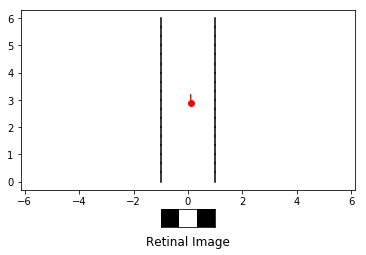

In [133]:
import matplotlib.gridspec as gridspec
import itertools
import matplotlib
import matplotlib.cm as cm

camera_pos = [0.1, 2.9]; camera_phi = np.pi/2
agent2.reset(camera_pos, camera_phi)
agent2.fov.update_retina(agent2.pos, agent2.dir-np.pi/2)

cell_angles = np.rad2deg(agent2.fov.get_cell_angles())

fig_len=10
gs = gridspec.GridSpec(2, 1,
                       height_ratios=[fig_len, 1])#@@

ax = plt.subplot(gs[0]) #@@

# Plot the camera
ax.scatter(camera_pos[0],camera_pos[1],c='r')
arrow_size = 0.03*fig_len;
arrow_vec = arrow_size* narr([np.cos(camera_phi), np.sin(camera_phi)])
ax.arrow(camera_pos[0],camera_pos[1], arrow_vec[0],arrow_vec[1],**{'color':'r', 'shape':'full'})

tag_it = (item[2] for item in agent2.fov.obj_list)
first_it, second_it = itertools.tee(tag_it,2)
norm = matplotlib.colors.Normalize(vmin=min(first_it), vmax=max(second_it), clip=False)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Greys)
    
for item in agent2.fov.obj_list:
    line = narr([item[0],item[1]])
    ax.set_facecolor('w')
    ax.plot(line[:,0],line[:,1],c='k')
ax.axis('equal')


cmap = mapper.cmap; cmap.set_under(color='w', alpha=None)

tretina = agent2.fov.retina
ax2 = plt.subplot(gs[1])#@@
ax2.imshow([tretina,], cmap=mapper.cmap)#, norm=norm)
ax2.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.set_title('Retinal Image', y=-1.3)
# if cell_angles is not None:
#     label_pos = np.arange(0,tretina.size, fig_len*2)
#     cell_labels = cell_angles[0:tretina.size:fig_len*2]
#     cell_labels = [ '%.f' % elem for elem in cell_labels]
#     ax2.set_xticks(label_pos)
#     ax2.set_xticklabels(cell_labels)

## Best Network Parameters and Topology

In [ ]:
# Plot the topology using pygraphviz
import pygraphviz as pgv
from itertools import combinations 
import matplotlib.image as mpimg

import datetime
from IPython.display import SVG, display
%display inline 


In [80]:
nn = agent2.nn

G1=pgv.AGraph(strict=False,directed=True)
for i in range(nn.Size):
    G1.add_node(str(i), xlabel='b='+("%.f" %nn.Bias[i]))
for node1 in G1.nodes():
    for node2 in G1.nodes():
        cweight = nn.Weight[int(node1),int(node2)]
        if cweight<0:
            ccolor = 'red'
        else:
            ccolor = 'green'
        G1.add_edge(node1,node2, penwidth=abs(cweight/15), color=ccolor)
#         G1.add_edge(node1,node2, weight=abs(cweight/15), color=ccolor)

for i in range(retina_len):
    G1.add_node('Retina'+str(i), style="filled", fillcolor='yellow')
    G1.add_edge('Retina'+str(i),str(i), label="%.f" % (agent2.gs[i]))

G1.add_node('Wing RX', style="filled", fillcolor='cyan')
G1.add_edge('3', 'Wing RX', label="%.f" % (agent2.gwrx))
G1.add_node('Wing RY', style="filled", fillcolor='cyan')
G1.add_edge('4', 'Wing RY', label="%.f" % (agent2.gwry))
G1.add_node('Wing LX', style="filled", fillcolor='cyan')
G1.add_edge('5', 'Wing LX', label="%.f" % (agent2.gwlx))
G1.add_node('Wing LY', style="filled", fillcolor='cyan')
G1.add_edge('6', 'Wing LY', label="%.f" % (agent2.gwly))

In [81]:
G1.layout(prog='circo')
datinow = datetime.datetime.now()
# anim.save('polecart_c_sample'+str(int(time.time()%100))+'.mp4',dpi=150)
G1.draw('network'+datinow.strftime("%b%d-%H-%M")+'.svg')
# display(SVG(url='test_net2.svg'))
# fig, ax = plt.subplots(figsize=(4, 4))
# ax.imshow(mpimg.imread('pcnet3.svg'))